Source Code: [linear_regression.py](https://github.com/KatieMacalintal/KatieMacalintal.github.io/blob/main/posts/linear-regression/linear_regression.py)

# Linear Regression  

In this blog post, we implement least-squares linear regression, which works to predict a real number for each data point based on its features. We also inspect overparameterized problems by experimenting with both our implemented `LinearRegression` class and the `sklearn.linear_model` class `Lasso`. 

## Implementation

*Resource: [Regression Notes](https://middlebury-csci-0451.github.io/CSCI-0451/lecture-notes/regression.html)* 

As discussed in this course, least-squares linear regression fits nicely into the friendly and easier to work with convex linear model framework. In our `LinearRegression` class, we implemented a linear `predict` function and a loss function that uses *squared error*, which is convex. In defining our `predict` and `loss` functions in these ways, we are then left with the empirical risk minimization problem of $$\hat{w}=\underset{w}{\arg\min}\sum_{i=1}^n(\langle{\mathbf{w}}, {\mathbf{x}}_i\rangle - y_i)^{2}=\underset{w}{\arg\min}\left\lVert\mathbf{Xw}-\mathbf{y}\right\rVert_2^2.$$

To solve this empirical risk minimization problem, we first take gradient with respect to $\hat{w}$, which results in $$\nabla L(w)=\mathbf{X}^T(\mathbf{Xw}-\mathbf{y}).$$

To continue solving this empirical risk minimization problem and find $\hat{w}$, we implemented two different fit methods in our `LinearRegression` class: `fit_analytic` and `fit_gradient`. 

In `fit_analytic`, we use a formula involving matrix inversion that is obtained by using the condition $\nabla L(w)=0$. This ultimately results in $$\hat{w}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$$ and the corresponding code `np.linalg.inv(X_.T@X_)@X_.T@y` for `w`. 

In `fit_gradient`, we use gradient descent and update t`w` until the change in loss is at its lowest and stops changing. Our gradient descent equation, $$\nabla L(w)=\mathbf{X}^T(\mathbf{Xw}-\mathbf{y})$$ is very expensive, where $\mathbf{X}^T\mathbf{X}$ has time complexity $O(np^2)$, and $\mathbf{X}^T\mathbf{y}$ has time complexity $O(np)$. But, since it doesn't depend on our current `w` we precompute $\mathbf{X}^T\mathbf{X}$ as ${P}$ and $\mathbf{X}^T\mathbf{y}$ as ${q}$. This allows our update to noly take $O(p^2)$ time. 

## Demo  

To demonstrate that we've implemented the `fit_analytic` and `fit_gradient` functions of our `LinearRegression` class correctly, we can test it on a dataset that has 1 feature to easily visualize the problem and results. We first define relavant functions that will help us with this demo. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

Next, we create our training and validation data, each of which have 100 data points, and as mentioned earlier 1 feature. 

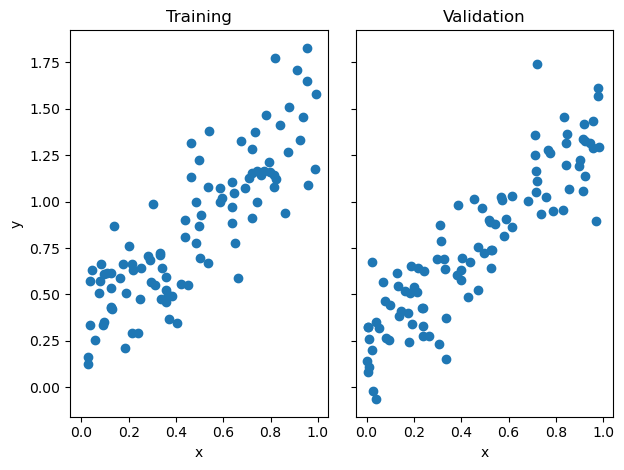

In [15]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

Now we can start fitting our model using our implemented `LinearRegression` class. We first test out our `fit_analytic` function.  

In [16]:
from linear_regression import LinearRegression

LR = LinearRegression()
LR.fit_analytic(X_train, y_train)

print(f"Training score = {LR.score(pad(X_train), y_train).round(4)}")
print(f"Validation score = {LR.score(pad(X_val), y_val).round(4)}")

Training score = 0.7128
Validation score = 0.7707


When we inspect our training and validation scores, we see that they may not be as high as the scores we would get on classification models in the past. This is because it all depends on the randomly generated data we get and how much noise is present in it. We can also inspect its estimated weight vector as shown below. 

In [17]:
LR.w

array([1.15124998, 0.31088572])

Next, we try testing out our `fit_gradient` function, and inspect its weight. 

In [21]:
LR2 = LinearRegression()

LR2.fit_gradient(X_train, y_train, alpha = 0.01, max_iter = 1e3)

In [22]:
LR2.w

array([1.15123929, 0.31089109])

We see that its weight is pretty close to the weight calculated in our `fit_analytic` function. Since our `fit_analytic` keeps track of the scores of the current weight, we can also inspect its `score_history`. 

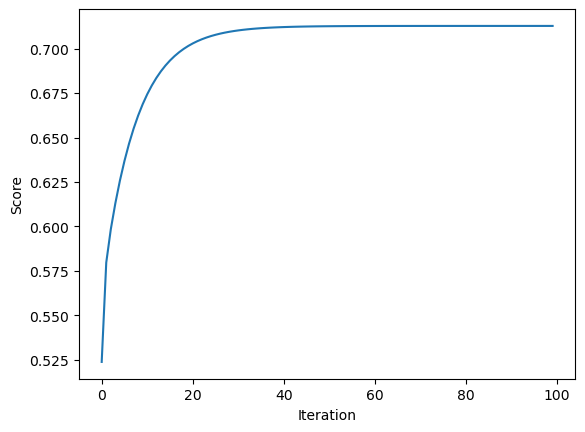

In [20]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")

As expected, we the score increases monotonically in each iteration. Based on our demo, it looks like our `LinearRegression` class is working adequately. 

## Linear Regression Experiments

Next, we want to explore what overparameterization can do to our model. To do so, we run an experiment where we increase `p_features`, the number of features used, but keep `n_train`, the number of training points, constant. We do this until `p_features` is all the way to `n_train - 1` and insect their change in training and validation scores. 

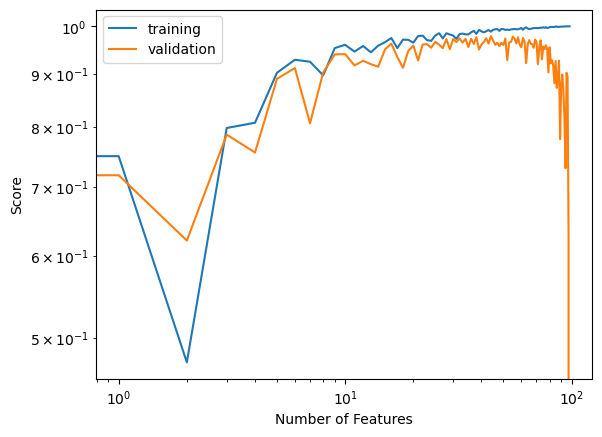

In [26]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR = LinearRegression()
    LR.fit_analytic(X_train, y_train)
    training_scores.append(LR.score(pad(X_train), y_train))
    validation_scores.append(LR.score(pad(X_val), y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

When we inspect our evolution of training scores, we see that generally as our number of features increases, our training score also increases and eventually reaches perfect training classification. When we inspect our evolution of validation scores, however, we see that as our number of features increases, our validation score decreases and eventually shoots down to a very low validation score.  
This graph evolution of the training and validation scores follows the pattern of overfitting. Here, as the number of features increase, we see a gap between the training and validation score get larger. Perhaps this tells us that the more features we use the more vulnerable we are to overfitting. 

## LASSO Regularization Experiments

Let's try the same experiment with the `LASSO` algorithm as provided through the `sklearn.linear_model`. This algorithm has a modified loss function with a regularization term, which makes the entries of the weight vector $\mathbf{w}$ small. LASSO tends to force entries of the weight vector to be exactly zero, which may be desirable in our experiments where we are increasing the number of features to the number of data points. 

We first experiment with a very low regularization term, where ${\alpha} = 0.0009$. 

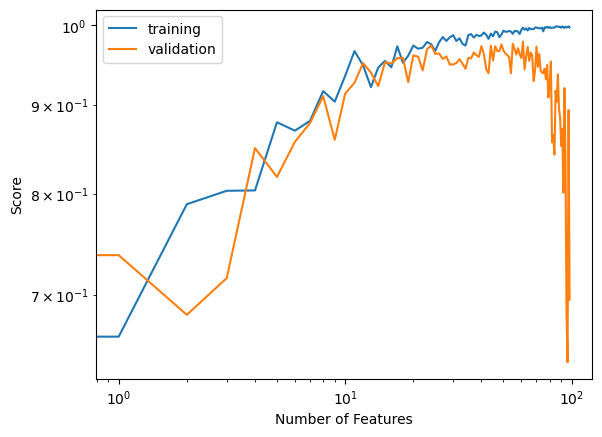

In [36]:
from sklearn.linear_model import Lasso
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.0009)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

We see that the results are very similar to what we saw with `LinearRegression` class, as our number of features increased our training score increased to perfect classification, but our validation score drastically decreased.  

If we increase our regularization strength and set ${\alpha} = 0.01$, we see different results. 

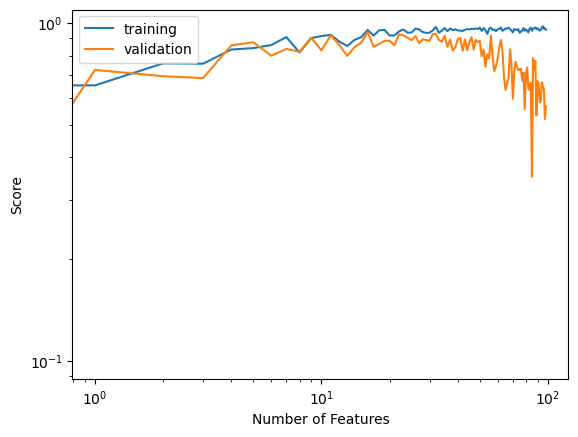

In [32]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.01)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

Here we see that as our number of features increased our training score still increasing to a close perfect classification, but our validation score is no longer as low as before. If we increase ${\alpha} = 0.01$, we see the gap between our training and validation score decrease even as our number of features increased. 

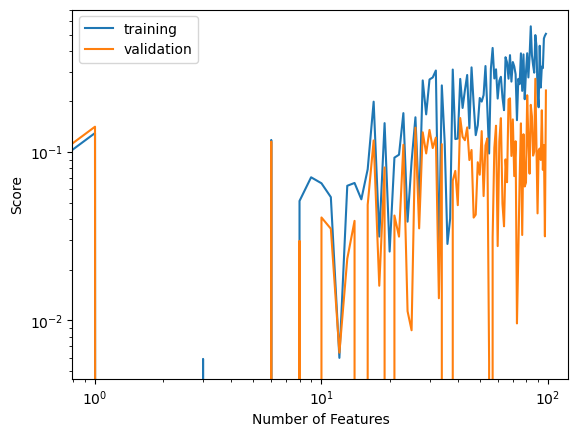

In [33]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train):
    L = Lasso(alpha = 0.1)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

Let's now see how the Lasso algorithm with a high regularization term can handle when our number of features goes past the number of data points we have. 

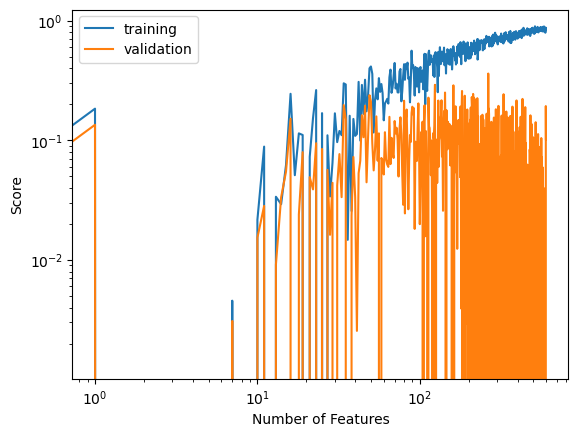

In [39]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

training_scores = []
validation_scores = []

while (p_features < n_train + 500):
    L = Lasso(alpha = 0.1)
    # create some data
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    training_scores.append(L.score(X_train, y_train))
    validation_scores.append(L.score(X_val, y_val))
    p_features += 1
    
plt.plot(training_scores, label="training")
plt.plot(validation_scores, label="validation")

plt.yscale('log')
plt.xscale('log')
legend = plt.legend() 
labels = plt.gca().set(xlabel = "Number of Features", ylabel = "Score")

Based on our graphs of scores, we see that the Lasso model keeps the validation score within the same range even as our number of features exceed our number of data points. 

As we see through these experiments, the LASSO algorithm handles overparameterization better than our least square linear regression model. 